# 04_05-pjt 권혁준, 김승수

## 프로젝트 설명

### 배경

추석은 한국의 대표적인 명절로, 매년 전국적으로 대규모 인구 이동이 발생한다. 귀성·귀경 행렬로 인한 교통 혼잡은 사회적 비용을 증가시키며, 

특정 지역은 과밀 현상을 겪는 반면 다른 지역은 상대적으로 한산한 모습을 보이기도 한다. 

그러나 기존의 언론 보도나 공공기관 발표는 주로 교통 정체 상황이나 물가 변동에 국한되어 있으며,

전국 시 단위에서의 유입·유출 인구 변화를 종합적으로 분석한 사례는 부족하다. 

이에 따라, 추석 연휴 기간 동안 실제로 어느 지역이 붐비고 한산한지를 정량적으로 확인할 필요성이 제기된다.

### 목적

본 프로젝트의 목적은 추석 연휴 기간 동안 전국 시 단위 방문자 수 데이터를 분석하여,

인구 패턴을 시각적으로 제시하고 의미 있는 인사이트를 도출하는 것이다. 이를 통해 다음과 같은 가치를 창출하고자 한다.

추석 연휴 기간 여행·관광지 선택을 위한 한산 지역 추천

장기적으로는 명절 기간 지역별 인구 분산 정책 및 교통 관리 전략 수립에 기여

## 데이터 수집

### 필요 라이브러리

In [1]:
# ==============================
# 1. 데이터 처리
# ==============================
import pandas as pd
import numpy as np

# ==============================
# 2. 데이터 수집
# ==============================
import requests
from bs4 import BeautifulSoup
import json

# ==============================
# 3. 시각화
# ==============================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium

# ==============================
# 4. 공간 데이터 분석
# ==============================
import geopandas as gpd
from shapely.geometry import Point, Polygon

# ==============================
# 5. 통계 / 머신러닝
# ==============================
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# ==============================
# 6. 결과 저장 / 공유
# ==============================
import openpyxl
from datetime import datetime


### 추석 기간 데이터프레임 제작

``` sql
create database pjt04_db;

USE pjt04_db;

CREATE TABLE chuseok_holiday (
    year INT PRIMARY KEY,              -- 연도
    start_date DATE NOT NULL,          -- 추석 연휴 시작일
    end_date DATE NOT NULL,            -- 추석 연휴 종료일
    start_day VARCHAR(10) NOT NULL,    -- 시작 요일
    end_day VARCHAR(10) NOT NULL       -- 종료 요일
);

INSERT INTO chuseok_holiday (year, start_date, end_date, start_day, end_day)
VALUES
(2022, '2022-09-08', '2022-09-12', '목', '월'),
(2023, '2023-09-27', '2023-10-03', '수', '화'),
(2024, '2024-09-13', '2024-09-18', '금', '수');

ALTER TABLE chuseok_holiday
ADD COLUMN holiday_days INT;

UPDATE chuseok_holiday
SET holiday_days = DATEDIFF(end_date, start_date) + 1;

ALTER TABLE chuseok_holiday
ADD COLUMN holiday_main DATE;

UPDATE chuseok_holiday
SET holiday_main = '2022-09-10'
WHERE year = 2022;

UPDATE chuseok_holiday
SET holiday_main = '2023-09-29'
WHERE year = 2023;

UPDATE chuseok_holiday
SET holiday_main = '2024-09-17'
WHERE year = 2024;
```

In [2]:
import pandas as pd

# CSV 파일 불러오기
df = pd.read_csv("data/chuseok_holiday.csv")

# 데이터 확인
print(df.shape)   # 행, 열 크기
print(df.head())  # 앞부분 미리보기


(3, 7)
   year  start_date    end_date start_day end_day  holiday_days holiday_main
0  2022  2022-09-08  2022-09-12         목       월             5   2022-09-10
1  2023  2023-09-27  2023-10-03         수       화             7   2023-09-29
2  2024  2024-09-13  2024-09-18         금       수             6   2024-09-17


### 연휴 시작 ~ 연휴 당일까지의 외지인 유입인구 수집

In [3]:
# 관광데이터랩에서 가져옴

# CSV 파일 불러오기
input_2022 = pd.read_csv("data/20220908-20220910_외지인유입인구.csv")
input_2023 = pd.read_csv("data/20230927-20230929_외지인유입인구.csv")
input_2024 = pd.read_csv("data/20240913-20240917_외지인유입인구.csv")

# 데이터 확인
print(input_2022.head())
print(input_2023.head())
print(input_2024.head())

    광역지자체명 기초지자체명  광역지자체 방문자 수  광역지자체 방문자 비율  기초지자체 방문자 수  기초지자체 방문자 비율
0  강원특별자치도    춘천시      2315450           5.9       448343          11.4
1  강원특별자치도    원주시      2315450           5.9       465518          11.9
2  강원특별자치도    강릉시      2315450           5.9       491841          12.5
3  강원특별자치도    동해시      2315450           5.9       195454           5.0
4  강원특별자치도    태백시      2315450           5.9        83534           2.1
    광역지자체명 기초지자체명  광역지자체 방문자 수  광역지자체 방문자 비율  기초지자체 방문자 수  기초지자체 방문자 비율
0  강원특별자치도    춘천시    2435293.0           5.7     456134.0          11.1
1  강원특별자치도    원주시    2435293.0           5.7     544268.0          13.2
2  강원특별자치도    강릉시    2435293.0           5.7     490581.0          11.9
3  강원특별자치도    동해시    2435293.0           5.7     196178.0           4.8
4  강원특별자치도    태백시    2435293.0           5.7      96814.0           2.3
    광역지자체명 기초지자체명  광역지자체 방문자 수  광역지자체 방문자 비율  기초지자체 방문자 수  기초지자체 방문자 비율
0  강원특별자치도    춘천시    3976038.0           6.2     695664.0       

### 전국 위경도 데이터 수집

In [4]:
# CSV 파일 불러오기
long_lat = pd.read_csv("data/전국 중심 좌표데이터.csv")

# 데이터 확인
print(long_lat.head())

      시도  시군구    읍면동 하위         위도          경도          코드 코드종류
0  서울특별시  종로구  청운효자동  -  37.584009  126.970626  1111051500    H
1  서울특별시  종로구    사직동  -  37.575408  126.965944  1111053000    H
2  서울특별시  종로구    삼청동  -  37.590758  126.980996  1111054000    H
3  서울특별시  종로구    부암동  -  37.594768  126.965574  1111055000    H
4  서울특별시  종로구    평창동  -  37.613029  126.974485  1111056000    H


### 지역별 인구수 데이터 수집

In [5]:
# 출처: KOSIS
population = pd.read_csv('data/people_count.csv')
population.head()

,광역지차제명,기초지자체명,인구수
0,서울특별시,종로구,"138,336"
1,서울특별시,중구,"120,544"
2,서울특별시,용산구,"203,854"
3,서울특별시,성동구,"273,669"
4,서울특별시,광진구,"331,963"


## 데이터 전처리

### 유동인구 데이터 전처리

#### 컬럼 설명

광역지자체 방문자 비율: 전체 방문자 수 대비 해당 광역지자체 방문 비율<br>
기초지자체 방문자 비율: 해당 광역지자체 전체 방문자 수 대비 해당 기초지자체 방문 비율

#### 전국 대비 해당 기초지자체 방문자 비율

In [6]:
# 전국 대비 해당 기초지자체 방문자 비율

# 전국 대비 기초지자체 방문자 비율 계산
input_2022["전국대비_방문자비율"] = input_2022["광역지자체 방문자 비율"] * input_2022["기초지자체 방문자 비율"] * 0.01
input_2023["전국대비_방문자비율"] = input_2023["광역지자체 방문자 비율"] * input_2023["기초지자체 방문자 비율"] * 0.01
input_2024["전국대비_방문자비율"] = input_2024["광역지자체 방문자 비율"] * input_2024["기초지자체 방문자 비율"] * 0.01

# 확인
print(input_2022["전국대비_방문자비율"].head(2))
print(input_2023["전국대비_방문자비율"].head(2))
print(input_2024["전국대비_방문자비율"].head(2))

0    0.6726
1    0.7021
Name: 전국대비_방문자비율, dtype: float64
0    0.6327
1    0.7524
Name: 전국대비_방문자비율, dtype: float64
0    0.6324
1    0.7130
Name: 전국대비_방문자비율, dtype: float64


#### 연도별 데이터 테이블 병합

In [7]:
import pandas as pd

# 데이터프레임들을 딕셔너리에 정리
dfs = {
    2022: input_2022,
    2023: input_2023,
    2024: input_2024
}

merged = None

for year, df in dfs.items():
    # 공통키 (그대로 유지)
    id_cols = ["광역지자체명", "기초지자체명"]

    # 다른 컬럼들에 연도 붙이기
    df_renamed = df.rename(columns={col: f"{col}_{year}" for col in df.columns if col not in id_cols})

    # 병합
    if merged is None:
        merged = df_renamed
    else:
        merged = pd.merge(merged, df_renamed, on=id_cols, how="outer")

# 결과 확인
print(merged.head())


    광역지자체명 기초지자체명  광역지자체 방문자 수_2022  광역지자체 방문자 비율_2022  기초지자체 방문자 수_2022  \
0  강원특별자치도    강릉시           2315450                5.9            491841   
1  강원특별자치도    고성군           2315450                5.9            190572   
2  강원특별자치도    동해시           2315450                5.9            195454   
3  강원특별자치도    삼척시           2315450                5.9            190634   
4  강원특별자치도    속초시           2315450                5.9            321258   

   기초지자체 방문자 비율_2022  전국대비_방문자비율_2022  광역지자체 방문자 수_2023  광역지자체 방문자 비율_2023  \
0               12.5           0.7375         2435293.0                5.7   
1                4.9           0.2891         2435293.0                5.7   
2                5.0           0.2950         2435293.0                5.7   
3                4.9           0.2891         2435293.0                5.7   
4                8.2           0.4838         2435293.0                5.7   

   기초지자체 방문자 수_2023  기초지자체 방문자 비율_2023  전국대비_방문자비율_2023  광역지자체 방문자 수_2024 

### 위경도 데이터 전처리

In [8]:
long_lat.info()
long_lat.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22219 entries, 0 to 22218
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시도      22219 non-null  object 
 1   시군구     22080 non-null  object 
 2   읍면동     22219 non-null  object 
 3   하위      22219 non-null  object 
 4   위도      22219 non-null  float64
 5   경도      22219 non-null  float64
 6   코드      22219 non-null  int64  
 7   코드종류    22219 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 1.4+ MB


,시도,시군구,읍면동,하위,위도,경도,코드,코드종류
0,서울특별시,종로구,청운효자동,-,37.584009,126.970626,1111051500,H
1,서울특별시,종로구,사직동,-,37.575408,126.965944,1111053000,H
2,서울특별시,종로구,삼청동,-,37.590758,126.980996,1111054000,H
3,서울특별시,종로구,부암동,-,37.594768,126.965574,1111055000,H
4,서울특별시,종로구,평창동,-,37.613029,126.974485,1111056000,H


#### 안쓰는 컬럼 제거, 지역명 중복되는 내용 제거

In [9]:
# 필요한 컬럼만 남기기
long_lat = long_lat[['시도', '시군구', '위도', '경도']]
long_lat.head()

# 시군구 기준으로 중복 제거 → 첫 번째 행만 남김
# 좌표 중복 제거는 반드시 ['시도','시군구'] 기준!
long_lat_unique = (
    long_lat
    .dropna(subset=["시도","시군구"])
    .drop_duplicates(subset=["시도","시군구"], keep="first")
)

print(long_lat_unique.head())
long_lat_unique.info()

       시도  시군구         위도          경도
0   서울특별시  종로구  37.584009  126.970626
17  서울특별시   중구  37.564079  126.980046
32  서울특별시  용산구  37.549901  126.980613
48  서울특별시  성동구  37.563386  127.037047
65  서울특별시  광진구  37.543250  127.073393
<class 'pandas.core.frame.DataFrame'>
Index: 262 entries, 0 to 13958
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시도      262 non-null    object 
 1   시군구     262 non-null    object 
 2   위도      262 non-null    float64
 3   경도      262 non-null    float64
dtypes: float64(2), object(2)
memory usage: 10.2+ KB


#### 행정구역 기준 위경도 병합

In [10]:
# merged
merged["행정구역"] = merged["광역지자체명"] + " " + merged["기초지자체명"]

# long_lat_unique
long_lat_unique["행정구역"] = long_lat_unique["시도"] + " " + long_lat_unique["시군구"]

# merge
df_final = pd.merge(
    merged,
    long_lat_unique[["행정구역", "위도", "경도"]],
    on="행정구역",
    how="left"
)


In [11]:
# 결측치 확인

print(df_final["위도"].isna().sum())
# 위도가 결측치인 행 전체 출력
missing_rows = df_final[df_final["위도"].isna()]
print(missing_rows)


0
Empty DataFrame
Columns: [광역지자체명, 기초지자체명, 광역지자체 방문자 수_2022, 광역지자체 방문자 비율_2022, 기초지자체 방문자 수_2022, 기초지자체 방문자 비율_2022, 전국대비_방문자비율_2022, 광역지자체 방문자 수_2023, 광역지자체 방문자 비율_2023, 기초지자체 방문자 수_2023, 기초지자체 방문자 비율_2023, 전국대비_방문자비율_2023, 광역지자체 방문자 수_2024, 광역지자체 방문자 비율_2024, 기초지자체 방문자 수_2024, 기초지자체 방문자 비율_2024, 전국대비_방문자비율_2024, 행정구역, 위도, 경도]
Index: []


#### 고유값을 만들기 위해 광역지자체명과 기초지자체명을 합쳐 행정구역 컬럼 생성

In [12]:
population["행정구역"] = population["광역지차제명"] + " " + population["기초지자체명"]
population.head()

,광역지차제명,기초지자체명,인구수,행정구역
0,서울특별시,종로구,"138,336",서울특별시 종로구
1,서울특별시,중구,"120,544",서울특별시 중구
2,서울특별시,용산구,"203,854",서울특별시 용산구
3,서울특별시,성동구,"273,669",서울특별시 성동구
4,서울특별시,광진구,"331,963",서울특별시 광진구


#### 행정구역별 인구수 병합

In [13]:
df_real_final = pd.merge(
    df_final,
    population[["인구수", "행정구역"]],
    on="행정구역",
    how="left"
)
# df_real_final.head()
df_real_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   광역지자체명             229 non-null    object 
 1   기초지자체명             229 non-null    object 
 2   광역지자체 방문자 수_2022   229 non-null    int64  
 3   광역지자체 방문자 비율_2022  229 non-null    float64
 4   기초지자체 방문자 수_2022   229 non-null    int64  
 5   기초지자체 방문자 비율_2022  229 non-null    float64
 6   전국대비_방문자비율_2022    229 non-null    float64
 7   광역지자체 방문자 수_2023   229 non-null    float64
 8   광역지자체 방문자 비율_2023  229 non-null    float64
 9   기초지자체 방문자 수_2023   229 non-null    float64
 10  기초지자체 방문자 비율_2023  229 non-null    float64
 11  전국대비_방문자비율_2023    229 non-null    float64
 12  광역지자체 방문자 수_2024   229 non-null    float64
 13  광역지자체 방문자 비율_2024  229 non-null    float64
 14  기초지자체 방문자 수_2024   229 non-null    float64
 15  기초지자체 방문자 비율_2024  229 non-null    float64
 16  전국대비_방문자비율_2024    229 non

### 전처리 완료 데이터

In [14]:
df_real_final.sample(5)

,광역지자체명,기초지자체명,광역지자체 방문자 수_2022,광역지자체 방문자 비율_2022,기초지자체 방문자 수_2022,기초지자체 방문자 비율_2022,전국대비_방문자비율_2022,광역지자체 방문자 수_2023,광역지자체 방문자 비율_2023,기초지자체 방문자 수_2023,...,전국대비_방문자비율_2023,광역지자체 방문자 수_2024,광역지자체 방문자 비율_2024,기초지자체 방문자 수_2024,기초지자체 방문자 비율_2024,전국대비_방문자비율_2024,행정구역,위도,경도,인구수
86,경상북도,청송군,3468255,8.9,114552,2.0,0.1780,3711316.0,8.7,118674.0,...,0.1653,5444033.0,8.5,166086.0,1.8,0.1530,경상북도 청송군,36.423023,129.098370,"23,716"
137,서울특별시,서대문구,5325383,13.7,631659,3.7,0.5069,5684728.0,13.4,645603.0,...,0.4958,8629782.0,13.5,1083642.0,3.9,0.5265,서울특별시 서대문구,37.567945,126.959437,"302,853"
173,전라남도,무안군,2530566,6.5,239134,5.5,0.3575,2769179.0,6.5,250208.0,...,0.3510,4106578.0,6.4,377912.0,5.5,0.3520,전라남도 무안군,34.992461,126.471291,"92,687"
107,대전광역시,중구,1017415,2.6,454615,19.5,0.5070,1110893.0,2.6,486437.0,...,0.5018,1701098.0,2.7,798756.0,19.3,0.5211,대전광역시 중구,36.332381,127.416782,"225,008"
226,충청북도,진천군,1845792,4.7,179616,5.2,0.2444,2012703.0,4.7,175301.0,...,0.2256,2836351.0,4.4,250187.0,4.7,0.2068,충청북도 진천군,36.847832,127.414079,"86,537"


## EDA

### 최근 년도 기초지자체 방문자 수 상위 TOP 10 시각화

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_2272\2551740883.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


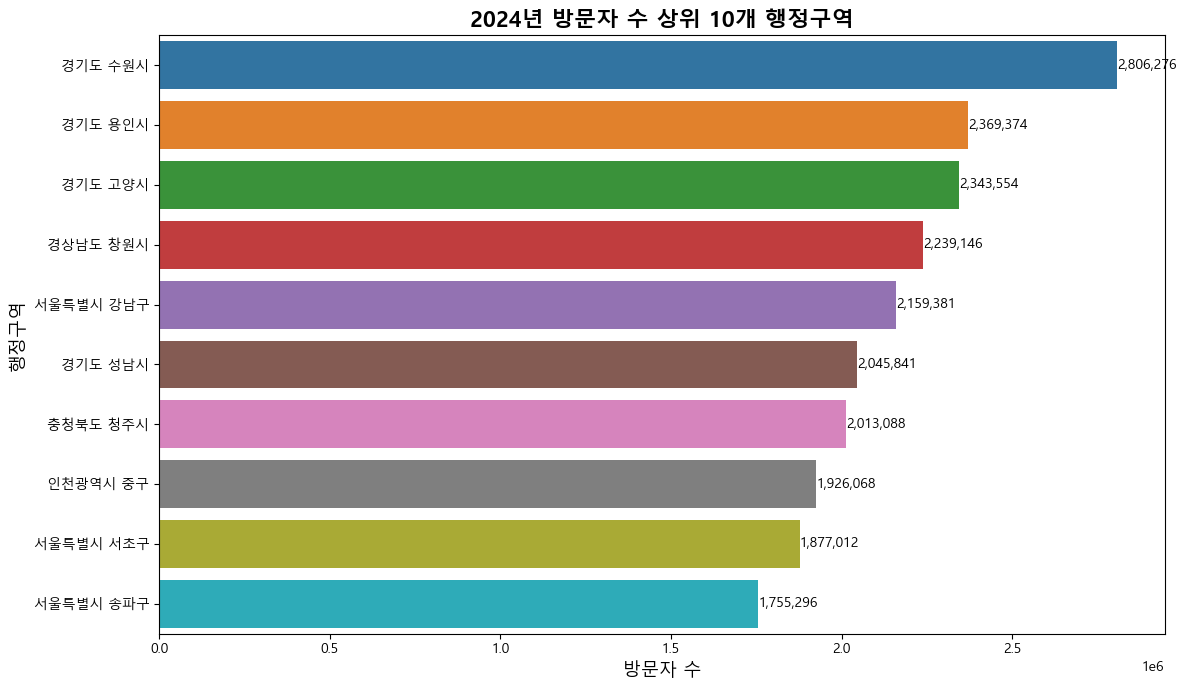

In [15]:
plt.rc("font", family="Malgun Gothic")  # 한글 폰트
plt.rc("axes", unicode_minus=False)

# 2024년 방문자 수 TOP10
top_10 = (
    df_final[["행정구역", "기초지자체 방문자 수_2024"]]
    .sort_values(by="기초지자체 방문자 수_2024", ascending=False)
    .head(10)
)

plt.figure(figsize=(12, 7))
sns.barplot(
    data=top_10,
    x="기초지자체 방문자 수_2024",
    y="행정구역",
    palette="tab10"
)

plt.title("2024년 방문자 수 상위 10개 행정구역", fontsize=16, weight="bold")
plt.xlabel("방문자 수", fontsize=13)
plt.ylabel("행정구역", fontsize=13)

# 값 라벨 표시
for index, value in enumerate(top_10["기초지자체 방문자 수_2024"]):
    plt.text(value, index, f"{int(value):,}", va="center", ha="left", fontsize=10)

plt.tight_layout()
plt.show()


### 최근 년도 기초지자체 방문자 수 하위 TOP 10 시각화

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_2272\224990061.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


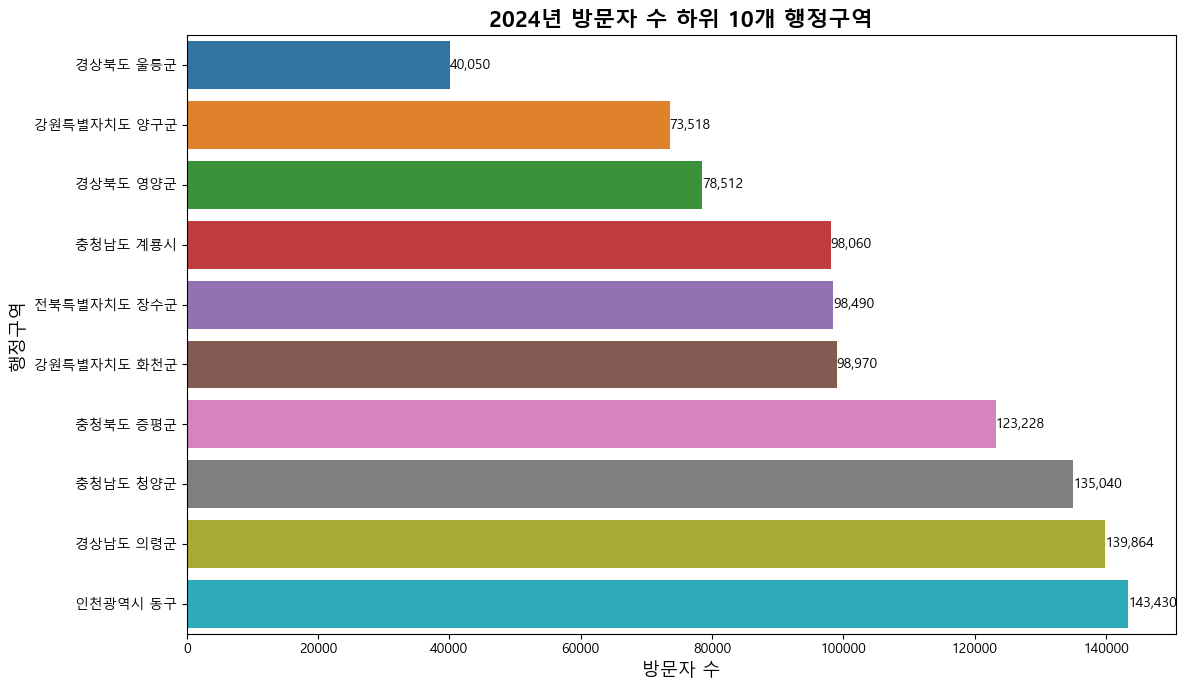

In [16]:
plt.rc("font", family="Malgun Gothic")  # 한글 폰트
plt.rc("axes", unicode_minus=False)

# 2024년 방문자 수 TOP10
top_10 = (
    df_final[["행정구역", "기초지자체 방문자 수_2024"]]
    .sort_values(by="기초지자체 방문자 수_2024", ascending=True)
    .head(10)
)

plt.figure(figsize=(12, 7))
sns.barplot(
    data=top_10,
    x="기초지자체 방문자 수_2024",
    y="행정구역",
    palette="tab10"
)

plt.title("2024년 방문자 수 하위 10개 행정구역", fontsize=16, weight="bold")
plt.xlabel("방문자 수", fontsize=13)
plt.ylabel("행정구역", fontsize=13)

# 값 라벨 표시
for index, value in enumerate(top_10["기초지자체 방문자 수_2024"]):
    plt.text(value, index, f"{int(value):,}", va="center", ha="left", fontsize=10)

plt.tight_layout()
plt.show()


### 방문자 수 증감 추이 시각화

#### 증감률 계산

In [17]:
# -----------------------------
# 1. 증감률(%) 계산
# -----------------------------
cols = [
    "행정구역",
    "기초지자체 방문자 수_2022",
    "기초지자체 방문자 수_2023",
    "기초지자체 방문자 수_2024",
]
df_rate = df_final[cols].copy()

# 증감률 = (올해 - 전년) / 전년 * 100
df_rate["2023년 증감률"] = (df_rate["기초지자체 방문자 수_2023"] - df_rate["기초지자체 방문자 수_2022"]) / df_rate["기초지자체 방문자 수_2022"] * 100
df_rate["2024년 증감률"] = (df_rate["기초지자체 방문자 수_2024"] - df_rate["기초지자체 방문자 수_2023"]) / df_rate["기초지자체 방문자 수_2023"] * 100

# -----------------------------
# 2. Long 형태 변환
# -----------------------------
df_rate_long = df_rate.melt(
    id_vars=["행정구역"],
    value_vars=["2023년 증감률", "2024년 증감률"],
    var_name="구분",          # <- 바꿈
    value_name="증감률(%)"
)

#### 증감률 기준 TOP10 시각화

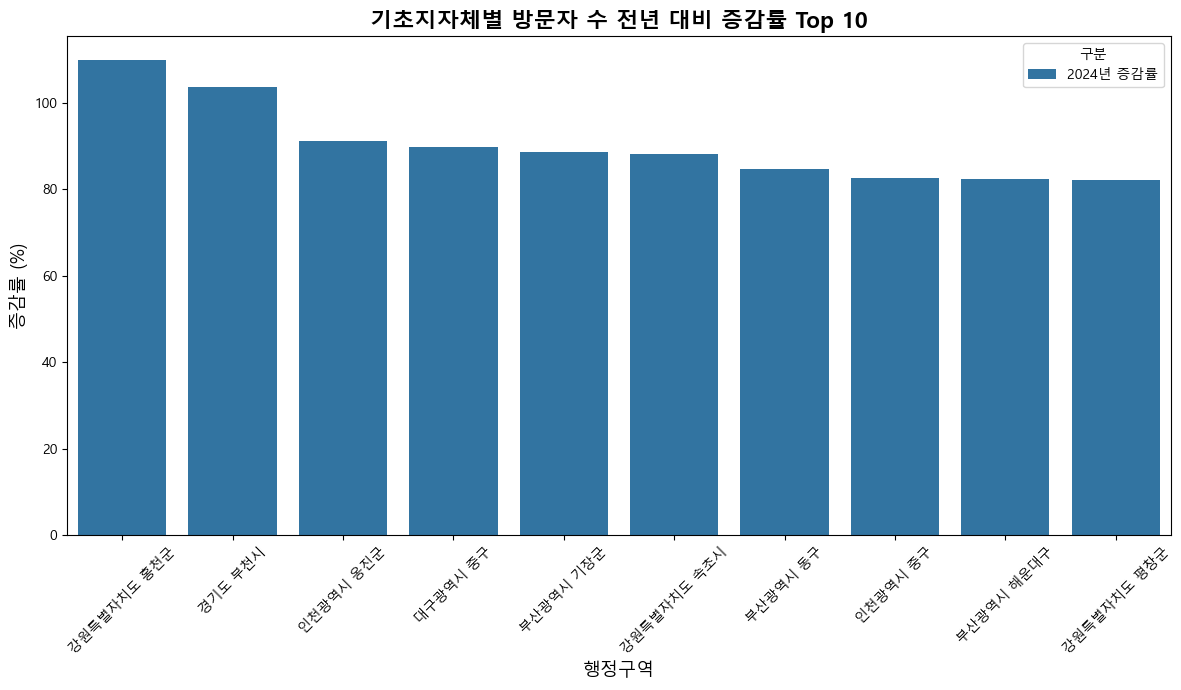

In [18]:
# -----------------------------
# 3. 증감률 높은 순 Top10 추출
# -----------------------------
top10_rate = (
    df_rate_long.sort_values(by="증감률(%)", ascending=False)
    .head(10)
)

# -----------------------------
# 4. 시각화
# -----------------------------
plt.figure(figsize=(12, 7))
sns.barplot(
    data=top10_rate,
    x="행정구역",
    y="증감률(%)",
    hue="구분",            # <- 바꿈
    palette="tab10"
)

plt.title("기초지자체별 방문자 수 전년 대비 증감률 Top 10", fontsize=16, weight="bold")
plt.xlabel("행정구역", fontsize=13)
plt.ylabel("증감률 (%)", fontsize=13)
plt.xticks(rotation=45)
plt.legend(title="구분")   # <- 바꿈
plt.tight_layout()
plt.show()

#### 2024년 전국 기초지자체별 방문자 수 및 분포

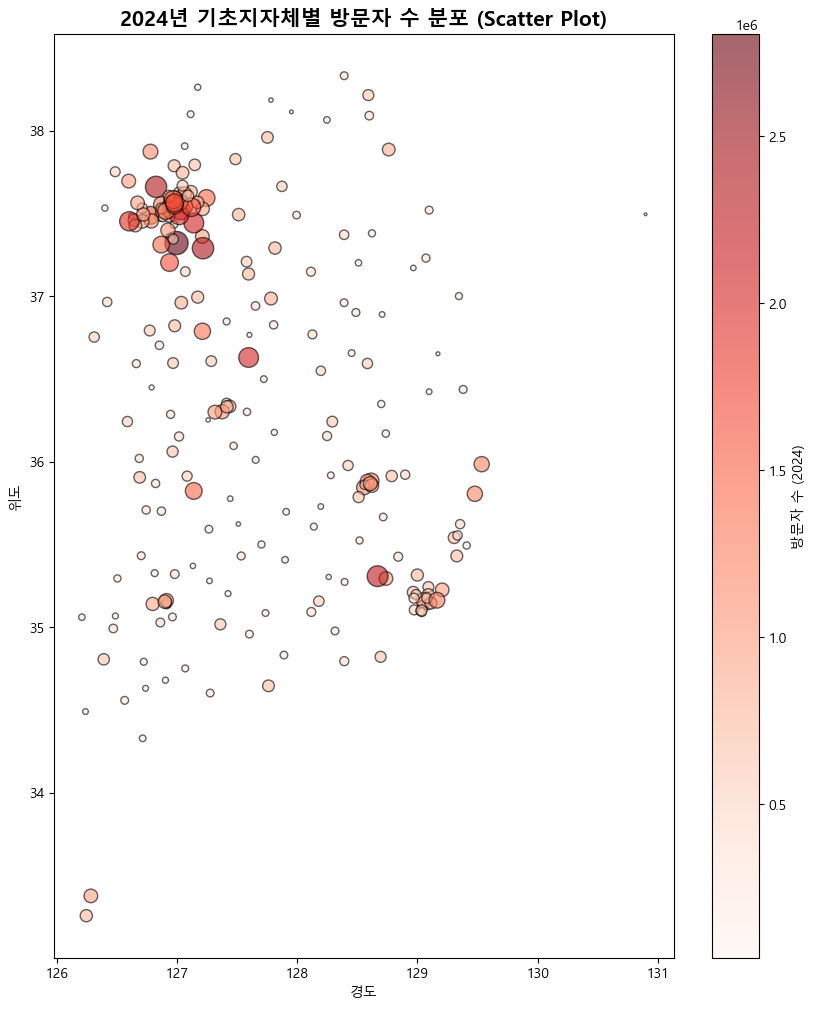

In [19]:
plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)

# -----------------------------
# 1. 사용할 데이터 선택 (예: 2024년 기준)
# -----------------------------
df_plot = df_final[["기초지자체명", "위도", "경도", "기초지자체 방문자 수_2024"]].copy()

# -----------------------------
# 2. Scatter Plot
# -----------------------------
plt.figure(figsize=(10, 12))

scatter = plt.scatter(
    df_plot["경도"],  # x축: 경도
    df_plot["위도"],  # y축: 위도
    s=df_plot["기초지자체 방문자 수_2024"] / 10000,  # 점 크기 (스케일 조정 필요)
    c=df_plot["기초지자체 방문자 수_2024"],          # 점 색상
    cmap="Reds",
    alpha=0.6,
    edgecolors="k"
)

plt.colorbar(scatter, label="방문자 수 (2024)")
plt.title("2024년 기초지자체별 방문자 수 분포 (Scatter Plot)", fontsize=15, weight="bold")
plt.xlabel("경도")
plt.ylabel("위도")

plt.show()


#### 2024년 전국 기초지자체별 방문자 수 증감률 및 분포

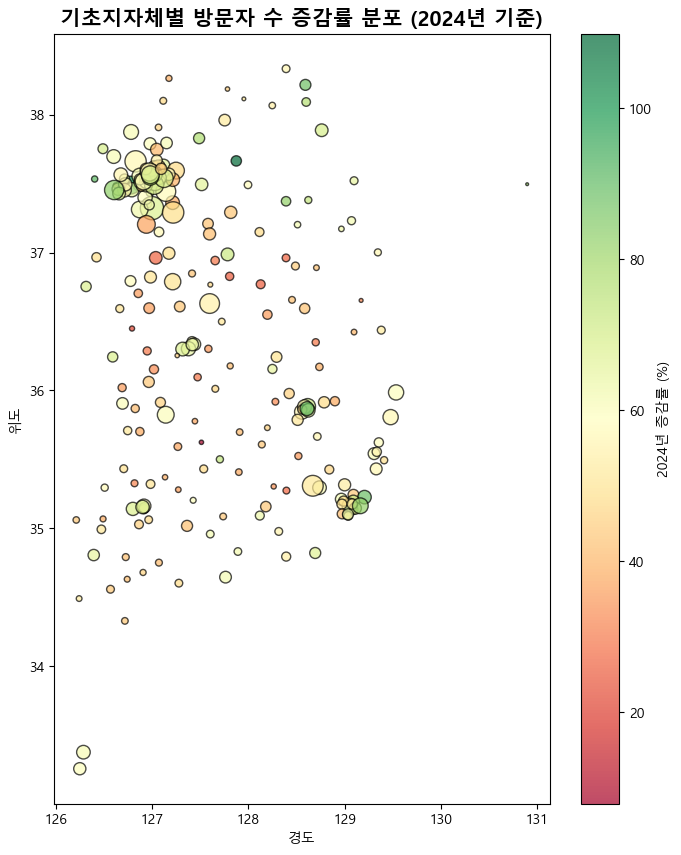

In [20]:
plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)

# -----------------------------
# 1. 증감률 계산
# -----------------------------
df_rate_map = df_final.copy()
df_rate_map["2023년 증감률"] = (df_rate_map["기초지자체 방문자 수_2023"] - df_rate_map["기초지자체 방문자 수_2022"]) / df_rate_map["기초지자체 방문자 수_2022"] * 100
df_rate_map["2024년 증감률"] = (df_rate_map["기초지자체 방문자 수_2024"] - df_rate_map["기초지자체 방문자 수_2023"]) / df_rate_map["기초지자체 방문자 수_2023"] * 100

# -----------------------------
# 2. 시각화 (예: 2024년 증감률)
# -----------------------------
plt.figure(figsize=(8, 10))
scatter = plt.scatter(
    df_rate_map["경도"], 
    df_rate_map["위도"],
    s=df_rate_map["기초지자체 방문자 수_2024"] / 10000,   # 방문자 수 비례 크기
    c=df_rate_map["2024년 증감률"],                       # 색상 = 2024년 증감률
    cmap="RdYlGn",    # Red=감소, Green=증가 느낌
    alpha=0.7,
    edgecolors="k"
)

plt.colorbar(scatter, label="2024년 증감률 (%)")
plt.title("기초지자체별 방문자 수 증감률 분포 (2024년 기준)", fontsize=15, weight="bold")
plt.xlabel("경도")
plt.ylabel("위도")
plt.show()


#### 서울·경기도·인천광역시 기초지자체별 방문자 수 증감률 분포 (2024년 기준)

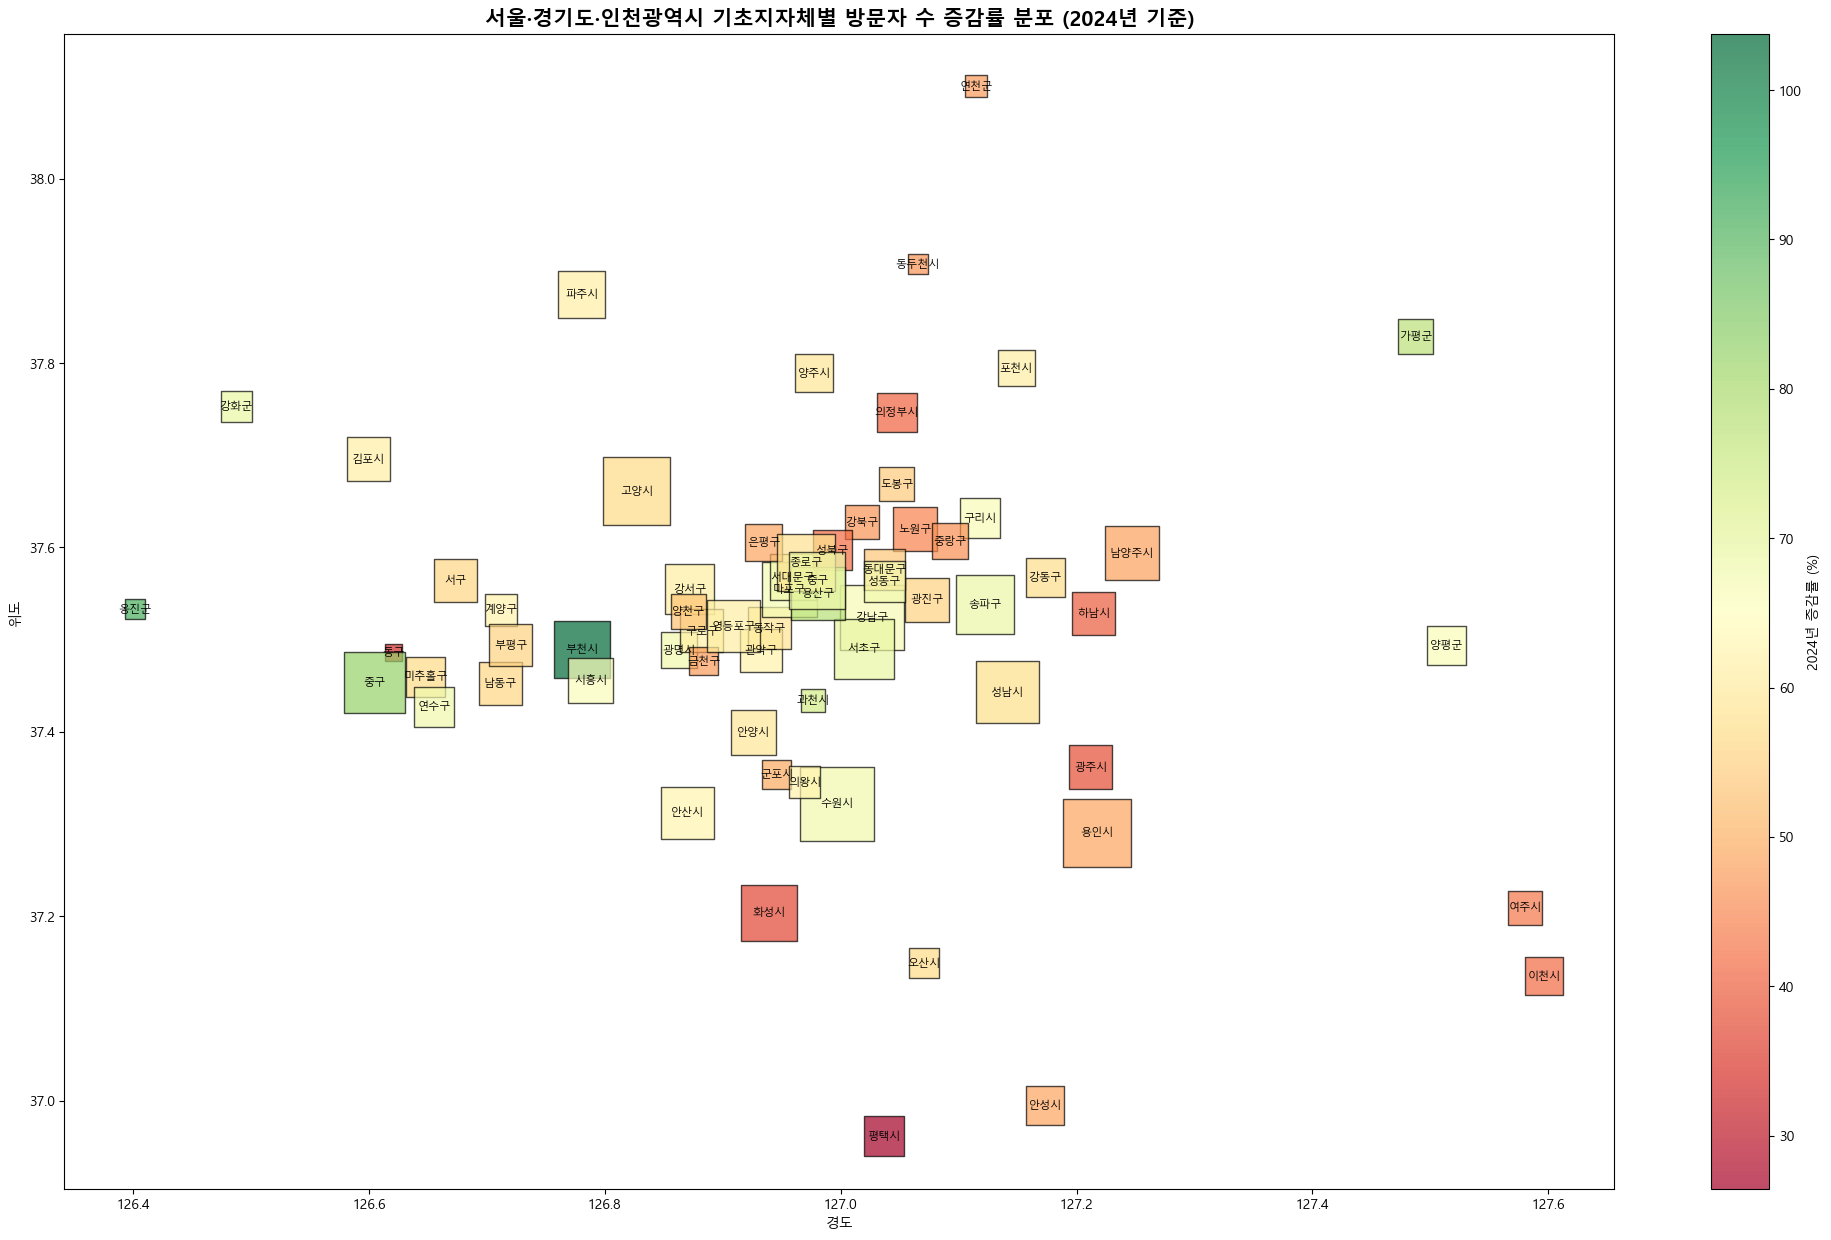

In [21]:
plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)

# -----------------------------
# 1. 경기도 + 서울 데이터 필터링
# -----------------------------
df_region = df_final[df_final["광역지자체명"].isin(["경기도", "서울특별시","인천광역시"])].copy()

# 증감률 계산
df_region["2023년 증감률"] = (
    (df_region["기초지자체 방문자 수_2023"] - df_region["기초지자체 방문자 수_2022"]) 
    / df_region["기초지자체 방문자 수_2022"] * 100
)
df_region["2024년 증감률"] = (
    (df_region["기초지자체 방문자 수_2024"] - df_region["기초지자체 방문자 수_2023"]) 
    / df_region["기초지자체 방문자 수_2023"] * 100
)

# -----------------------------
# 2. Scatter Plot (2024년 증감률 기준)
# -----------------------------
plt.figure(figsize=(25, 15))
scatter = plt.scatter(
    df_region["경도"],
    df_region["위도"],
    s=df_region["기초지자체 방문자 수_2024"] / 1000,   # 점 크기 = 방문자 수
    c=df_region["2024년 증감률"],                       # 색상 = 2024년 증감률
    cmap="RdYlGn",
    alpha=0.7,
    edgecolors="k",
    marker="s"
)



# -----------------------------
# 3. 보조 설정
# -----------------------------
plt.colorbar(scatter, label="2024년 증감률 (%)")
plt.title("서울·경기도·인천광역시 기초지자체별 방문자 수 증감률 분포 (2024년 기준)", fontsize=15, weight="bold")
plt.xlabel("경도")
plt.ylabel("위도")

# 각 기초지자체명 라벨 표시
for _, row in df_region.iterrows():
    plt.text(
        row["경도"], row["위도"],
        row["기초지자체명"],
        fontsize=8, ha="center", va="center"
    )

plt.show()


## 탐색 모델

### 거주지 인근 방문자 수 낮은 지역 탐색기

In [22]:
# 거주지
home = "수원시"
#탐색 희망 지역
close_area = ["경기도", "서울특별시", "강원도"]

In [23]:
from math import radians, sin, cos, sqrt, atan2

# -----------------------------
# 1. 인근지역 필터링
# -----------------------------
df_seoul_gyeonggi_incheon = df_final[df_final["광역지자체명"].isin(close_area)].copy()

# -----------------------------
# 2. 방문자 수 적은 20개 기초지자체 (2024년 기준)
# -----------------------------
df_bottom20 = (
    df_seoul_gyeonggi_incheon
    .nsmallest(20, "기초지자체 방문자 수_2024")
    .copy()
)

# -----------------------------
# 3. 목표지역 좌표 가져오기
# -----------------------------
suwon = df_final[df_final["기초지자체명"] == home].iloc[0]
suwon_lat, suwon_lon = suwon["위도"], suwon["경도"]

# -----------------------------
# 4. Haversine 거리 계산 함수 (단위 km)
# -----------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # 지구 반지름 (km)
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# -----------------------------
# 5. 각 지역까지 거리 계산
# -----------------------------
df_bottom20["목표지역까지 거리(km)"] = df_bottom20.apply(
    lambda row: haversine(suwon_lat, suwon_lon, row["위도"], row["경도"]),
    axis=1
)

# 6. 결과를 거리 기준으로 정렬 (오름차순)
df_result = df_bottom20.sort_values(by="목표지역까지 거리(km)", ascending=True)

print(df_result[["광역지자체명", "기초지자체명", "기초지자체 방문자 수_2024", "목표지역까지 거리(km)"]])



    광역지자체명 기초지자체명  기초지자체 방문자 수_2024  목표지역까지 거리(km)
41     경기도    의왕시          522680.0       3.589349
24     경기도    군포시          432660.0       5.768129
20     경기도    과천시          298238.0      12.595142
131  서울특별시    금천구          413126.0      19.918225
39     경기도    오산시          477680.0      20.264064
21     경기도    광명시          683340.0      22.022533
142  서울특별시    양천구          626276.0      25.730839
125  서울특별시    강동구          788456.0      31.429683
145  서울특별시    은평구          683400.0      32.000893
148  서울특별시    중랑구          660678.0      32.787486
126  서울특별시    강북구          603589.0      34.024336
133  서울특별시    도봉구          608458.0      38.815911
33     경기도    안성시          752812.0      39.593597
35     경기도    양주시          741730.0      51.963858
37     경기도    여주시          584031.0      53.092947
46     경기도    포천시          684198.0      54.214375
43     경기도    이천시          755800.0      56.991392
27     경기도   동두천시          221582.0      65.384582
18     경기도    가평군          6379

#### 지역 분할 분석

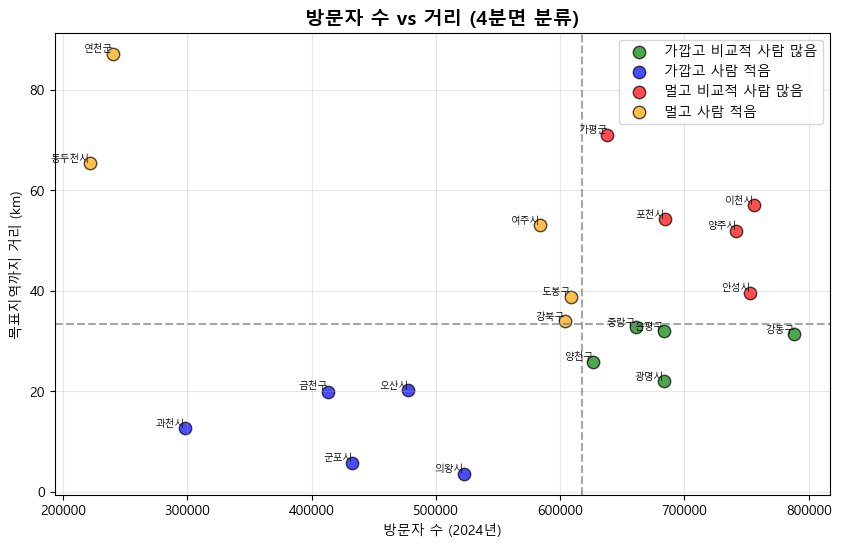

In [24]:

# -----------------------------
# 1. 기준값 계산 (중앙값 사용)
# -----------------------------
x_cut = df_result["기초지자체 방문자 수_2024"].median()
y_cut = df_result["목표지역까지 거리(km)"].median()

# -----------------------------
# 2. 카테고리 분류
# -----------------------------
def classify(row):
    if row["목표지역까지 거리(km)"] <= y_cut and row["기초지자체 방문자 수_2024"] <= x_cut:
        return "가깝고 사람 적음"
    elif row["목표지역까지 거리(km)"] <= y_cut and row["기초지자체 방문자 수_2024"] > x_cut:
        return "가깝고 비교적 사람 많음"
    elif row["목표지역까지 거리(km)"] > y_cut and row["기초지자체 방문자 수_2024"] <= x_cut:
        return "멀고 사람 적음"
    else:
        return "멀고 비교적 사람 많음"

df_result["분류"] = df_result.apply(classify, axis=1)

# -----------------------------
# 3. 산점도 시각화
# -----------------------------
plt.figure(figsize=(10, 6))

colors = {
    "가깝고 사람 적음": "blue",
    "가깝고 비교적 사람 많음": "green",
    "멀고 사람 적음": "orange",
    "멀고 비교적 사람 많음": "red"
}

for category, group in df_result.groupby("분류"):
    plt.scatter(
        group["기초지자체 방문자 수_2024"],
        group["목표지역까지 거리(km)"],
        s=80,
        c=colors[category],
        label=category,
        alpha=0.7,
        edgecolors="k"
    )
    # 라벨 표시
    for _, row in group.iterrows():
        plt.text(
            row["기초지자체 방문자 수_2024"],
            row["목표지역까지 거리(km)"],
            row["기초지자체명"],
            fontsize=7,
            ha="right",
            va="bottom"
        )

# 기준선 추가
plt.axvline(x_cut, color="gray", linestyle="--", alpha=0.7)
plt.axhline(y_cut, color="gray", linestyle="--", alpha=0.7)

plt.title("방문자 수 vs 거리 (4분면 분류)", fontsize=14, weight="bold")
plt.xlabel("방문자 수 (2024년)")
plt.ylabel("목표지역까지 거리 (km)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### 인근 낮은 방문자 수 지역 탐색(희망 탐색지 포함 )

In [25]:
from math import radians, sin, cos, sqrt, atan2

# Haversine 거리 계산 함수
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # 지구 반지름 (km)
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# 가고 싶은 지역 리스트
favorite_places = [
    ("충청남도", "태안군"),
    ("충청남도", "보령시"),
    ("전라남도", "목포시"),
    ("전라남도", "여수시"),
    ("전라남도", "담양군"),
    ("전라남도", "해남군"),
    ("전북특별자치도", "전주시"),
    ("전북특별자치도", "군산시"),
    ("전북특별자치도", "고창군"),
    ("전북특별자치도", "부안군"),
]

# 기준 지역 설정 (예: 유성구)
base = df_final[df_final["기초지자체명"] == "유성구"].iloc[0]
base_lat, base_lon = base["위도"], base["경도"]

# 가고 싶은 지역 데이터프레임 생성
df_fav = df_final.merge(
    pd.DataFrame(favorite_places, columns=["광역지자체명", "기초지자체명"]),
    on=["광역지자체명", "기초지자체명"],
    how="inner"
).copy()

# 거리 계산
df_fav["유성구 거리(km)"] = df_fav.apply(
    lambda row: haversine(base_lat, base_lon, row["위도"], row["경도"]),
    axis=1
)

# 결과 정렬
df_fav = df_fav.sort_values(by="유성구 거리(km)", ascending=True)

print(df_fav[["광역지자체명", "기초지자체명", "유성구 거리(km)", "기초지자체 방문자 수_2024"]])


    광역지자체명 기초지자체명  유성구 거리(km)  기초지자체 방문자 수_2024
7  전북특별자치도    전주시   55.269855         1458496.0
8     충청남도    보령시   65.503240          540960.0
5  전북특별자치도    군산시   71.259701          690708.0
6  전북특별자치도    부안군   83.450495          351810.0
9     충청남도    태안군  102.908959          543886.0
4  전북특별자치도    고창군  111.157730          314766.0
0     전라남도    담양군  112.939841          395272.0
1     전라남도    목포시  185.981087          666379.0
2     전라남도    여수시  188.299853          707287.0
3     전라남도    해남군  205.259045          314338.0


# 04_05-pjt (02. 머신러닝)

## 추가 데이터(인구수, 고령화지수) 처리

### 추가 데이터 수집 및 전처리

In [26]:
df_new = pd.read_excel("data/2023_고령화_인구수통합.xlsx")

In [27]:
df_2023_visits = pd.read_csv("data/202301-202312_방문자수.csv")

In [28]:
# 기존 df_final 과 병합 (광역지자체명 + 기초지자체명 기준)
df_real_final = pd.merge(
    df_real_final,
    df_new,
    on=["광역지자체명", "기초지자체명"],
    how="left"
)

# 확인
print(df_real_final.info())
# print(df_real_final.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   광역지자체명             229 non-null    object 
 1   기초지자체명             229 non-null    object 
 2   광역지자체 방문자 수_2022   229 non-null    int64  
 3   광역지자체 방문자 비율_2022  229 non-null    float64
 4   기초지자체 방문자 수_2022   229 non-null    int64  
 5   기초지자체 방문자 비율_2022  229 non-null    float64
 6   전국대비_방문자비율_2022    229 non-null    float64
 7   광역지자체 방문자 수_2023   229 non-null    float64
 8   광역지자체 방문자 비율_2023  229 non-null    float64
 9   기초지자체 방문자 수_2023   229 non-null    float64
 10  기초지자체 방문자 비율_2023  229 non-null    float64
 11  전국대비_방문자비율_2023    229 non-null    float64
 12  광역지자체 방문자 수_2024   229 non-null    float64
 13  광역지자체 방문자 비율_2024  229 non-null    float64
 14  기초지자체 방문자 수_2024   229 non-null    float64
 15  기초지자체 방문자 비율_2024  229 non-null    float64
 16  전국대비_방문자비율_2024    229 non

In [29]:
# 기존 df_final 과 병합 (광역지자체명 + 기초지자체명 기준)
df_real_final = pd.merge(
    df_real_final,
    df_2023_visits,
    on=["광역지자체명", "기초지자체명"],
    how="left"
)

# 확인
# print(df_real_final.info())
print(df_real_final.head())

    광역지자체명 기초지자체명  광역지자체 방문자 수_2022  광역지자체 방문자 비율_2022  기초지자체 방문자 수_2022  \
0  강원특별자치도    강릉시           2315450                5.9            491841   
1  강원특별자치도    고성군           2315450                5.9            190572   
2  강원특별자치도    동해시           2315450                5.9            195454   
3  강원특별자치도    삼척시           2315450                5.9            190634   
4  강원특별자치도    속초시           2315450                5.9            321258   

   기초지자체 방문자 비율_2022  전국대비_방문자비율_2022  광역지자체 방문자 수_2023  광역지자체 방문자 비율_2023  \
0               12.5           0.7375         2435293.0                5.7   
1                4.9           0.2891         2435293.0                5.7   
2                5.0           0.2950         2435293.0                5.7   
3                4.9           0.2891         2435293.0                5.7   
4                8.2           0.4838         2435293.0                5.7   

   기초지자체 방문자 수_2023  ...  전국대비_방문자비율_2024         행정구역         위도         

In [30]:
# # 기초지자체 방문자 수_y 컬럼 제거하고 기초지자체 방문자 수_x 에서 _x 지우기
# # 1) 불필요한 컬럼 제거
# df_real_final = df_real_final.drop(columns=["기초지자체 방문자 수_y"])

# # 2) _x 붙은 컬럼명 정리
# df_real_final = df_real_final.rename(columns={"기초지자체 방문자 수": "2023_전체 방문자 수"})

# # 확인
# print(df_real_final.head())


In [31]:
# 결측치 확인

# 1) 데이터프레임에서 null 값이 있는 행만 추출
df_null = df_real_final[df_real_final.isnull().any(axis=1)]

# 2) 결측치가 있는 행 출력
print(df_null)

# 3) 결측치 개수 요약 확인
print(df_real_final.isnull().sum())

Empty DataFrame
Columns: [광역지자체명, 기초지자체명, 광역지자체 방문자 수_2022, 광역지자체 방문자 비율_2022, 기초지자체 방문자 수_2022, 기초지자체 방문자 비율_2022, 전국대비_방문자비율_2022, 광역지자체 방문자 수_2023, 광역지자체 방문자 비율_2023, 기초지자체 방문자 수_2023, 기초지자체 방문자 비율_2023, 전국대비_방문자비율_2023, 광역지자체 방문자 수_2024, 광역지자체 방문자 비율_2024, 기초지자체 방문자 수_2024, 기초지자체 방문자 비율_2024, 전국대비_방문자비율_2024, 행정구역, 위도, 경도, 인구수, 2023_고령화지수, 고령화비율, 2023_인구수, 인구수비율, 기초지자체 방문자 수]
Index: []

[0 rows x 26 columns]
광역지자체명               0
기초지자체명               0
광역지자체 방문자 수_2022     0
광역지자체 방문자 비율_2022    0
기초지자체 방문자 수_2022     0
기초지자체 방문자 비율_2022    0
전국대비_방문자비율_2022      0
광역지자체 방문자 수_2023     0
광역지자체 방문자 비율_2023    0
기초지자체 방문자 수_2023     0
기초지자체 방문자 비율_2023    0
전국대비_방문자비율_2023      0
광역지자체 방문자 수_2024     0
광역지자체 방문자 비율_2024    0
기초지자체 방문자 수_2024     0
기초지자체 방문자 비율_2024    0
전국대비_방문자비율_2024      0
행정구역                 0
위도                   0
경도                   0
인구수                  0
2023_고령화지수           0
고령화비율                0
2023_인구수             0
인구수비율                0
기초지자체 방문자

In [32]:
# 인구수 컬럼을 숫자로 변환 (콤마 제거 후 float로)
df_real_final["인구수"] = (
    df_real_final["인구수"]
    .astype(str)             # 혹시 숫자 아닌 값이 섞여 있을 수 있으니 문자열로 변환
    .str.replace(",", "")    # 천 단위 구분기호 제거
    .astype(float)           # float 형으로 변환
)

# 확인
print(df_real_final["인구수"].head())
print(df_real_final["인구수"].dtype)


0    207731.0
1     26999.0
2     87675.0
3     61735.0
4     80933.0
Name: 인구수, dtype: float64
float64


### 상관관계 분석

2023년 인구수와 방문자 수 상관계수: 0.8817566140251298


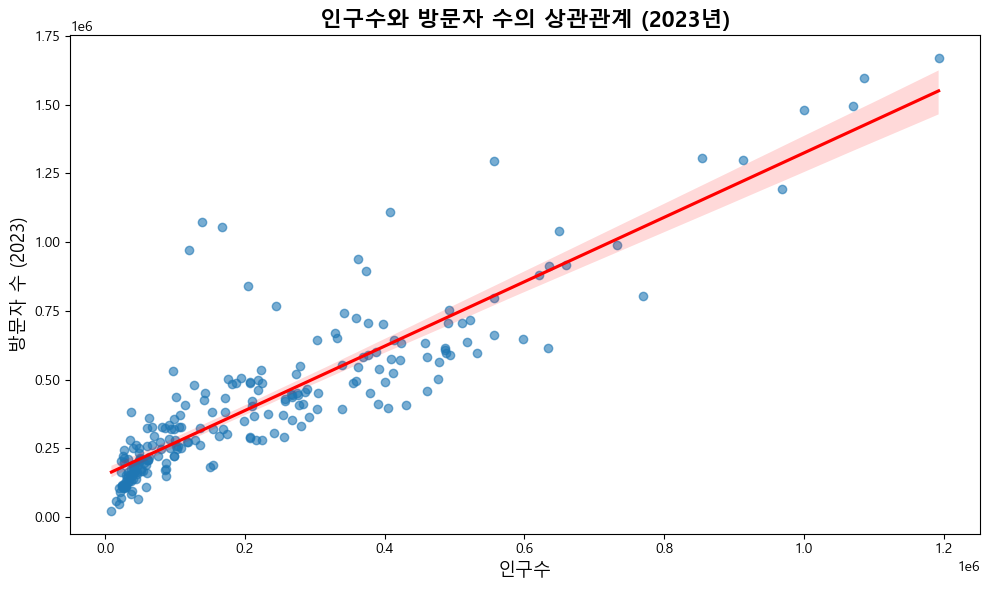

In [33]:
# 인구수와 방문자 수 상관관계

plt.rc("font", family="Malgun Gothic")  # 한글 폰트 적용
plt.rc("axes", unicode_minus=False)

# -----------------------------
# 1. 상관관계 계산
# -----------------------------
corr_value = df_real_final["인구수"].corr(df_real_final["기초지자체 방문자 수_2023"])
print("2023년 인구수와 방문자 수 상관계수:", corr_value)

# -----------------------------
# 2. 시각화 (산점도 + 회귀선)
# -----------------------------
plt.figure(figsize=(10,6))
sns.regplot(
    x="인구수",
    y="기초지자체 방문자 수_2023",
    data=df_real_final,
    scatter_kws={"alpha":0.6},
    line_kws={"color":"red"}
)

plt.title("인구수와 방문자 수의 상관관계 (2023년)", fontsize=16, weight="bold")
plt.xlabel("인구수", fontsize=13)
plt.ylabel("방문자 수 (2023)", fontsize=13)
plt.tight_layout()
plt.show()

2023년 고령화지수와 방문자 수 상관계수: -0.5338066235882536


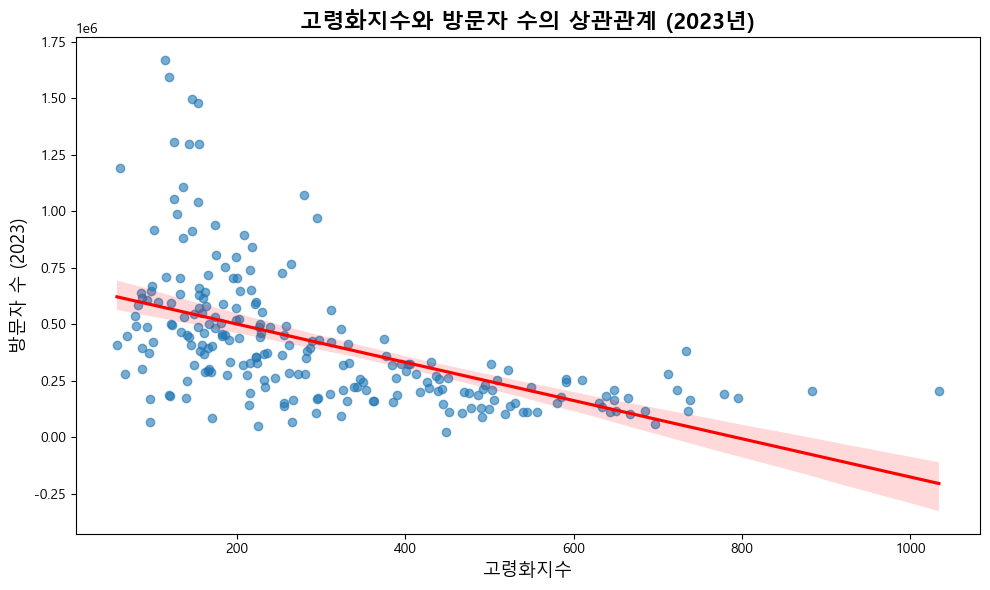

In [34]:
# 고령화지수와 방문자 수 상관관계

plt.rc("font", family="Malgun Gothic")  # 한글 폰트 적용
plt.rc("axes", unicode_minus=False)

# -----------------------------
# 1. 상관관계 계산
# -----------------------------
corr_value = df_real_final["2023_고령화지수"].corr(df_real_final["기초지자체 방문자 수_2023"])
print("2023년 고령화지수와 방문자 수 상관계수:", corr_value)

# -----------------------------
# 2. 시각화 (산점도 + 회귀선)
# -----------------------------
plt.figure(figsize=(10,6))
sns.regplot(
    x="2023_고령화지수",
    y="기초지자체 방문자 수_2023",
    data=df_real_final,
    scatter_kws={"alpha":0.6},
    line_kws={"color":"red"}
)

plt.title("고령화지수와 방문자 수의 상관관계 (2023년)", fontsize=16, weight="bold")
plt.xlabel("고령화지수", fontsize=13)
plt.ylabel("방문자 수 (2023)", fontsize=13)
plt.tight_layout()
plt.show()

In [35]:
df_real_final.describe()

,광역지자체 방문자 수_2022,광역지자체 방문자 비율_2022,기초지자체 방문자 수_2022,기초지자체 방문자 비율_2022,전국대비_방문자비율_2022,광역지자체 방문자 수_2023,광역지자체 방문자 비율_2023,기초지자체 방문자 수_2023,기초지자체 방문자 비율_2023,전국대비_방문자비율_2023,...,기초지자체 방문자 비율_2024,전국대비_방문자비율_2024,위도,경도,인구수,2023_고령화지수,고령화비율,2023_인구수,인구수비율,기초지자체 방문자 수
count,2.290000e+02,229.000000,2.290000e+02,229.000000,229.000000,2.290000e+02,229.000000,2.290000e+02,229.000000,229.000000,...,229.000000,229.000000,229.000000,229.000000,2.290000e+02,229.000000,229.000000,2.290000e+02,229.000000,2.290000e+02
mean,3.251753e+06,8.355895,4.022298e+05,7.422707,0.436934,3.537260e+06,8.310044,4.152047e+05,7.423581,0.435925,...,7.427074,0.436562,36.390848,127.654716,2.236560e+05,301.947598,7.424017,2.260896e+05,7.427948,3.390018e+07
std,1.927048e+06,4.951158,2.903990e+05,9.292499,0.278769,2.085574e+06,4.903537,2.967050e+05,9.327227,0.282153,...,9.437549,0.291539,1.087680,0.914817,2.234684e+05,187.278726,9.232147,2.254860e+05,10.726357,3.404993e+07
min,3.333120e+05,0.900000,1.921500e+04,0.300000,0.026700,3.602300e+05,0.800000,2.207100e+04,0.400000,0.034800,...,0.400000,0.034000,33.256446,126.210251,9.099000e+03,57.900000,0.900000,8.418000e+03,0.300000,1.722892e+06
25%,1.966122e+06,5.100000,1.906340e+05,3.000000,0.254800,2.225776e+06,5.200000,2.010080e+05,3.100000,0.254800,...,2.900000,0.238000,35.370442,126.934567,4.869000e+04,158.800000,3.200000,4.929400e+04,2.000000,1.040000e+07
50%,2.530566e+06,6.500000,3.242050e+05,5.000000,0.357500,2.769179e+06,6.500000,3.315200e+05,5.100000,0.361900,...,4.800000,0.361800,36.353853,127.362103,1.427890e+05,232.300000,5.100000,1.473780e+05,3.900000,2.450000e+07
75%,3.468255e+06,8.900000,5.202020e+05,7.800000,0.552000,3.711316e+06,8.700000,5.344360e+05,7.700000,0.564000,...,7.800000,0.569500,37.486203,128.488954,3.387850e+05,426.600000,8.100000,3.482720e+05,8.000000,4.560000e+07
max,7.161766e+06,18.400000,1.610896e+06,100.000000,1.748700,7.836804e+06,18.400000,1.669588e+06,100.000000,1.720400,...,100.000000,1.720400,38.332836,130.898288,1.193005e+06,1033.800000,100.000000,1.226362e+06,100.000000,2.200000e+08


2023년 전체 방문자 수와 추석 기간 방문자 수 상관계수: 0.9392757882346858


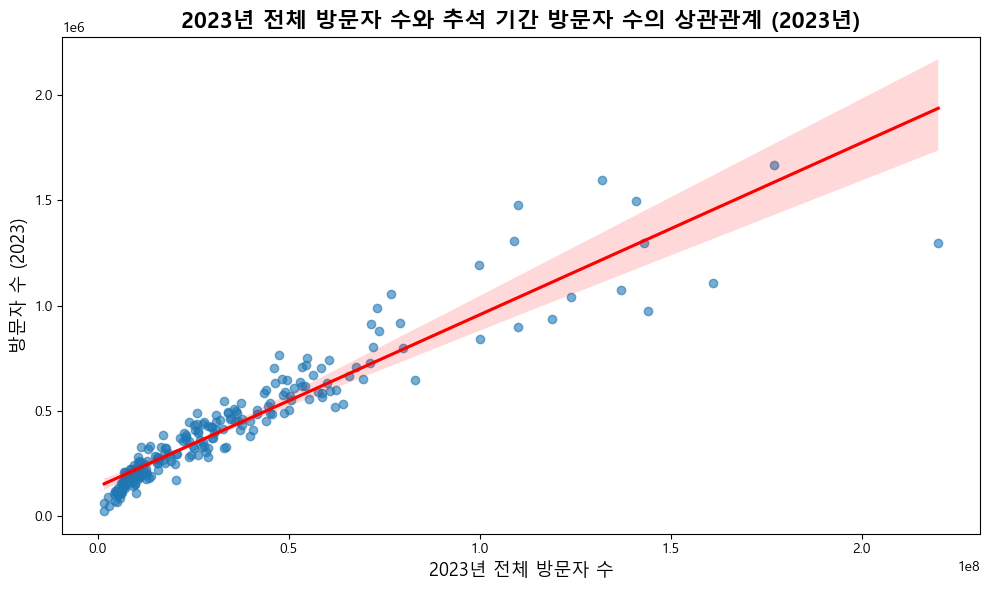

In [36]:
# 2023년 전체 방문자 수와 추석 기간 방문자 수 상관관계

plt.rc("font", family="Malgun Gothic")  # 한글 폰트 적용
plt.rc("axes", unicode_minus=False)

# -----------------------------
# 1. 상관관계 계산
# -----------------------------
corr_value = df_real_final["기초지자체 방문자 수"].corr(df_real_final["기초지자체 방문자 수_2023"])
print("2023년 전체 방문자 수와 추석 기간 방문자 수 상관계수:", corr_value)

# -----------------------------
# 2. 시각화 (산점도 + 회귀선)
# -----------------------------
plt.figure(figsize=(10,6))
sns.regplot(
    x="기초지자체 방문자 수",
    y="기초지자체 방문자 수_2023",
    data=df_real_final,
    scatter_kws={"alpha":0.6},
    line_kws={"color":"red"}
)

plt.title("2023년 전체 방문자 수와 추석 기간 방문자 수의 상관관계 (2023년)", fontsize=16, weight="bold")
plt.xlabel("2023년 전체 방문자 수", fontsize=13)
plt.ylabel("방문자 수 (2023)", fontsize=13)
plt.tight_layout()
plt.show()

### 추석 기간의 상대적 방문자 추이 확인

In [37]:
df_real_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   광역지자체명             229 non-null    object 
 1   기초지자체명             229 non-null    object 
 2   광역지자체 방문자 수_2022   229 non-null    int64  
 3   광역지자체 방문자 비율_2022  229 non-null    float64
 4   기초지자체 방문자 수_2022   229 non-null    int64  
 5   기초지자체 방문자 비율_2022  229 non-null    float64
 6   전국대비_방문자비율_2022    229 non-null    float64
 7   광역지자체 방문자 수_2023   229 non-null    float64
 8   광역지자체 방문자 비율_2023  229 non-null    float64
 9   기초지자체 방문자 수_2023   229 non-null    float64
 10  기초지자체 방문자 비율_2023  229 non-null    float64
 11  전국대비_방문자비율_2023    229 non-null    float64
 12  광역지자체 방문자 수_2024   229 non-null    float64
 13  광역지자체 방문자 비율_2024  229 non-null    float64
 14  기초지자체 방문자 수_2024   229 non-null    float64
 15  기초지자체 방문자 비율_2024  229 non-null    float64
 16  전국대비_방문자비율_2024    229 non

In [38]:
# 미사용 컬럼 삭제
df_real_final.drop(['광역지자체 방문자 비율_2022', '광역지자체 방문자 비율_2023', '광역지자체 방문자 비율_2024',
                   '기초지자체 방문자 비율_2022', '기초지자체 방문자 비율_2023', '기초지자체 방문자 비율_2024',
                   '전국대비_방문자비율_2022', '전국대비_방문자비율_2023', '전국대비_방문자비율_2024'], axis=1, inplace=True)

df_real_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   광역지자체명            229 non-null    object 
 1   기초지자체명            229 non-null    object 
 2   광역지자체 방문자 수_2022  229 non-null    int64  
 3   기초지자체 방문자 수_2022  229 non-null    int64  
 4   광역지자체 방문자 수_2023  229 non-null    float64
 5   기초지자체 방문자 수_2023  229 non-null    float64
 6   광역지자체 방문자 수_2024  229 non-null    float64
 7   기초지자체 방문자 수_2024  229 non-null    float64
 8   행정구역              229 non-null    object 
 9   위도                229 non-null    float64
 10  경도                229 non-null    float64
 11  인구수               229 non-null    float64
 12  2023_고령화지수        229 non-null    float64
 13  고령화비율             229 non-null    float64
 14  2023_인구수          229 non-null    int64  
 15  인구수비율             229 non-null    float64
 16  기초지자체 방문자 수       229 non-null    float64
dt

In [39]:
df_real_final['추석방문자비율'] = round(df_real_final['기초지자체 방문자 수_2023'] / df_real_final['기초지자체 방문자 수'] * 100, 2)
df_real_final.head()
df_real_final['추석방문자비율'].describe()

count    229.000000
mean       1.569258
std        0.524861
min        0.590000
25%        1.190000
50%        1.430000
75%        1.870000
max        3.430000
Name: 추석방문자비율, dtype: float64

In [40]:
# 0~100으로 스케일링
df_real_final["추석방문자비율_scaled"] = (
    df_real_final["추석방문자비율"] / df_real_final["추석방문자비율"].max()
) * 100

# 확인
print(df_real_final[["추석방문자비율", "추석방문자비율_scaled"]].head())
print("원본 최대값:", df_real_final["추석방문자비율"].max())
print("스케일링 후 최대값:", df_real_final["추석방문자비율_scaled"].max())

   추석방문자비율  추석방문자비율_scaled
0     1.43       41.690962
1     1.54       44.897959
2     1.65       48.104956
3     1.72       50.145773
4     1.32       38.483965
원본 최대값: 3.43
스케일링 후 최대값: 100.0


In [41]:
# 추석방문자비율_scaled 기준 상위 10개 추출
top10 = (
    df_real_final[["행정구역", "추석방문자비율_scaled", '기초지자체 방문자 수_2023']]
    .nlargest(10, "추석방문자비율_scaled")
)

print(top10)

            행정구역  추석방문자비율_scaled  기초지자체 방문자 수_2023
78      경상북도 영양군      100.000000           59437.0
197  전북특별자치도 장수군       94.169096           91298.0
166     전라남도 고흥군       89.795918          208674.0
72      경상북도 문경시       84.256560          326802.0
84      경상북도 의성군       83.381924          206986.0
94     대구광역시 군위군       76.676385          204102.0
218     충청북도 괴산군       76.676385          281036.0
196  전북특별자치도 임실군       76.093294          222257.0
219     충청북도 단양군       75.510204          243806.0
73      경상북도 봉화군       74.927114          117302.0


In [42]:
# 하위 10개
bottom10 = (
    df_real_final[["행정구역", "추석방문자비율_scaled", '기초지자체 방문자 수_2023']]
    .nsmallest(10, "추석방문자비율_scaled")
)

print(bottom10)

           행정구역  추석방문자비율_scaled  기초지자체 방문자 수_2023
124   서울특별시 강남구       17.201166         1296008.0
147    서울특별시 중구       19.533528          971702.0
138   서울특별시 서초구       20.116618         1107796.0
137  서울특별시 서대문구       22.740525          645603.0
146   서울특별시 종로구       22.740525         1071679.0
136   서울특별시 마포구       23.032070          938074.0
143  서울특별시 영등포구       23.615160          895587.0
102    대구광역시 중구       23.906706          530425.0
20      경기도 과천시       24.489796          171546.0
139   서울특별시 성동구       24.489796          519393.0


#### 이상치 제거
* 저평소 방문 지역 (예: 영양군): 평소 방문자가 거의 없어, 소수의 방문 증가만으로도 추석방문자비율이 급등 → 비율 과대평가
* 고평소 방문 지역 (예: 강남구): 평소 방문자가 워낙 많아, 추석 특수 효과가 묻혀 추석방문자비율이 낮게 계산됨 → 비율 과소평가
* 제거 기준: 추석 기간 방문자 수 스케일이 상하위 각각 10위 이내인데도 불구하고 10만 명 이하 or 100만 명 이상

#### 시사점

* 단순히 "추석방문자비율" 지표만으로 지역의 추석 특수 효과를 평가하기 어렵다.
* 평소 방문자 수 규모(분모 효과)를 고려해야 하며, 이상치를 감안한 보정 또는 **로버스트 지표(예: 중앙값 기준 표준화)**가 필요하다.

In [43]:
# 이상치 지역 목록
outliers = [
    {"광역지자체명": "경상북도", "기초지자체명": "영양군"},
    {"광역지자체명": "전북특별자치도", "기초지자체명": "장수군"},
    {"광역지자체명": "서울특별시", "기초지자체명": "강남구"},
    {"광역지자체명": "서울특별시", "기초지자체명": "서초구"},
    {"광역지자체명": "서울특별시", "기초지자체명": "종로구"}
]

# DataFrame에서 제외
df_filtered = df_real_final.copy()
for o in outliers:
    df_filtered = df_filtered[
        ~((df_filtered["광역지자체명"] == o["광역지자체명"]) &
          (df_filtered["기초지자체명"] == o["기초지자체명"]))
    ]

# 확인
print("이상치 제거 전:", df_real_final.shape)
print("이상치 제거 후:", df_filtered.shape)


이상치 제거 전: (229, 19)
이상치 제거 후: (224, 19)


In [44]:
# 추석방문자비율_scaled 기준 상위 10개 추출
top10 = (
    df_filtered[["행정구역", "추석방문자비율_scaled", '기초지자체 방문자 수_2023']]
    .nlargest(10, "추석방문자비율_scaled")
)

print(top10)

            행정구역  추석방문자비율_scaled  기초지자체 방문자 수_2023
166     전라남도 고흥군       89.795918          208674.0
72      경상북도 문경시       84.256560          326802.0
84      경상북도 의성군       83.381924          206986.0
94     대구광역시 군위군       76.676385          204102.0
218     충청북도 괴산군       76.676385          281036.0
196  전북특별자치도 임실군       76.093294          222257.0
219     충청북도 단양군       75.510204          243806.0
73      경상북도 봉화군       74.927114          117302.0
180     전라남도 완도군       74.344023          157392.0
66      경상남도 합천군       72.886297          173117.0


In [45]:
# 하위 10개
bottom10 = (
    df_filtered[["행정구역", "추석방문자비율_scaled", '기초지자체 방문자 수_2023']]
    .nsmallest(10, "추석방문자비율_scaled")
)

print(bottom10)

           행정구역  추석방문자비율_scaled  기초지자체 방문자 수_2023
147    서울특별시 중구       19.533528          971702.0
137  서울특별시 서대문구       22.740525          645603.0
136   서울특별시 마포구       23.032070          938074.0
143  서울특별시 영등포구       23.615160          895587.0
102    대구광역시 중구       23.906706          530425.0
20      경기도 과천시       24.489796          171546.0
139   서울특별시 성동구       24.489796          519393.0
141   서울특별시 송파구       24.489796         1038992.0
144   서울특별시 용산구       24.489796          841004.0
29      경기도 성남시       26.530612         1298854.0


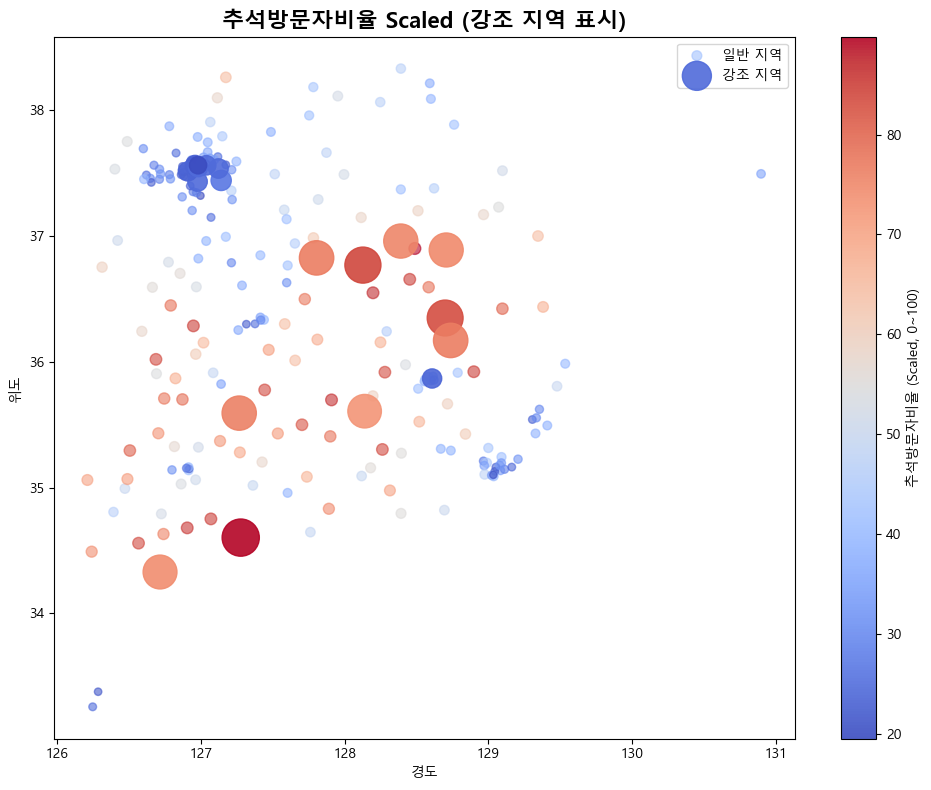

In [46]:
plt.rc("font", family="Malgun Gothic")  # 한글 폰트
plt.rc("axes", unicode_minus=False)

# -----------------------------
# 1. 강조할 지역 리스트 정의
# -----------------------------
highlight_regions = [
    "전라남도 고흥군", "경상북도 문경시", "경상북도 의성군", "대구광역시 군위군", "충청북도 괴산군",
    "전북특별자치도 임실군", "충청북도 단양군", "경상북도 봉화군", "전라남도 완도군", "경상남도 합천군",
    "서울특별시 중구", "서울특별시 서대문구", "서울특별시 마포구", "서울특별시 영등포구", "대구광역시 중구",
    "경기도 과천시", "서울특별시 성동구", "서울특별시 송파구", "서울특별시 용산구", "경기도 성남시"
]

# -----------------------------
# 2. 강조 여부 컬럼 추가
# -----------------------------
df_filtered["강조"] = df_filtered["행정구역"].isin(highlight_regions)

# -----------------------------
# 3. 산점도 시각화
# -----------------------------
plt.figure(figsize=(10, 8))

# 일반 지역 (작은 점)
plt.scatter(
    df_filtered.loc[~df_filtered["강조"], "경도"],
    df_filtered.loc[~df_filtered["강조"], "위도"],
    c=df_filtered.loc[~df_filtered["강조"], "추석방문자비율_scaled"],
    s=df_filtered.loc[~df_filtered["강조"], "추석방문자비율_scaled"],
    cmap="coolwarm",
    alpha=0.6,
    label="일반 지역"
)

# 강조 지역 (더 큰 점)
plt.scatter(
    df_filtered.loc[df_filtered["강조"], "경도"],
    df_filtered.loc[df_filtered["강조"], "위도"],
    c=df_filtered.loc[df_filtered["강조"], "추석방문자비율_scaled"],
    s=df_filtered.loc[df_filtered["강조"], "추석방문자비율_scaled"]*8,  # 배율 ↑
    cmap="coolwarm",
    alpha=0.9,
    marker="o",
    label="강조 지역"
)

plt.colorbar(label="추석방문자비율 (Scaled, 0~100)")
plt.title("추석방문자비율 Scaled (강조 지역 표시)", fontsize=16, weight="bold")
plt.xlabel("경도")
plt.ylabel("위도")
plt.legend()
plt.tight_layout()
plt.show()


* 강조 지역(상하위 20곳)은 다른 점보다 더 크게 표시하여 시각적으로 강조

### 머신러닝

#### 추가 데이터

In [47]:
df_2022_old = pd.read_excel("data/2022_고령화지수.xlsx")
df_2022_population = pd.read_excel("data/2022_인구.xlsx")
df_2024_population = pd.read_excel("data/2024_인구.xlsx")
df_2022_visit = pd.read_csv("data/202201-202212_방문자수.csv")
df_2024_visit = pd.read_csv("data/202401-202412_방문자수.csv")

In [48]:
# 추가한 데이터들 병함
from functools import reduce
import pandas as pd

dfs = [df_2022_visit, df_2022_old, df_2022_population, df_2024_population, df_2024_visit]

df_additive = reduce(
    lambda left, right: pd.merge(left, right, on=["광역지자체명", "기초지자체명"], how="left"),
    dfs
)

df_additive.info()


# 기존 df_real_final 과 병합 (광역지자체명 + 기초지자체명 기준)
df_real_final = pd.merge(
    df_real_final,
    df_new,
    on=["광역지자체명", "기초지자체명"],
    how="left"
)

# 확인
print(df_real_final.info())
# print(df_real_final.head())
print(df_additive.info())
# print(df_additive.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   광역지자체명            229 non-null    object 
 1   기초지자체명            229 non-null    object 
 2   2022 기초지자체 방문자 수  229 non-null    float64
 3   2022고령화지수         229 non-null    float64
 4   2022인구수           229 non-null    int64  
 5   2024인구수           177 non-null    float64
 6   2024 기초지자체 방문자 수  229 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 12.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   광역지자체명            229 non-null    object 
 1   기초지자체명            229 non-null    object 
 2   광역지자체 방문자 수_2022  229 non-null    int64  
 3   기초지자체 방문자 수_2022  229 non-null    int64  
 4   광역지자체 방문자 수_2023  

In [49]:
# 기존 df_real_final 과 병합 (광역지자체명 + 기초지자체명 기준)
df_true_final = pd.merge(
    df_real_final,
    df_additive,
    on=["광역지자체명", "기초지자체명"],
    how="left"
)

# 확인
print(df_real_final.info())
# print(df_real_final.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   광역지자체명            229 non-null    object 
 1   기초지자체명            229 non-null    object 
 2   광역지자체 방문자 수_2022  229 non-null    int64  
 3   기초지자체 방문자 수_2022  229 non-null    int64  
 4   광역지자체 방문자 수_2023  229 non-null    float64
 5   기초지자체 방문자 수_2023  229 non-null    float64
 6   광역지자체 방문자 수_2024  229 non-null    float64
 7   기초지자체 방문자 수_2024  229 non-null    float64
 8   행정구역              229 non-null    object 
 9   위도                229 non-null    float64
 10  경도                229 non-null    float64
 11  인구수               229 non-null    float64
 12  2023_고령화지수_x      229 non-null    float64
 13  고령화비율_x           229 non-null    float64
 14  2023_인구수_x        229 non-null    int64  
 15  인구수비율_x           229 non-null    float64
 16  기초지자체 방문자 수       229 non-null    float64
 1

In [55]:
df_additive.columns

Index(['광역지자체명', '기초지자체명', '2022 기초지자체 방문자 수', '2022고령화지수', '2022인구수',
       '2024인구수', '2024 기초지자체 방문자 수'],
      dtype='object')

In [73]:
# 1. 중복되는 컬럼들 정리 (_x만 남기고, _y는 삭제)
df_cleaned = df_true_final.drop(
    columns=[col for col in df_true_final.columns if col.endswith("_y")]
)

# 2. 남은 _x 컬럼 이름에서 "_x" 제거
df_cleaned.rename(
    columns={col: col.replace("_x", "") for col in df_cleaned.columns if col.endswith("_x")},
    inplace=True
)

# 3. 확인
print(df_cleaned.columns)

Index(['광역지자체명', '기초지자체명', '광역지자체 방문자 수_2022', '기초지자체 방문자 수_2022',
       '광역지자체 방문자 수_2023', '기초지자체 방문자 수_2023', '광역지자체 방문자 수_2024',
       '기초지자체 방문자 수_2024', '행정구역', '위도', '경도', '인구수', '2023_고령화지수', '고령화비율',
       '2023_인구수', '인구수비율', '기초지자체 방문자 수', '추석방문자비율', '추석방문자비율_scaled',
       '2022 기초지자체 방문자 수', '2022고령화지수', '2022인구수', '2024인구수',
       '2024 기초지자체 방문자 수'],
      dtype='object')


In [74]:
# 2024인구수 컬럼의 결측치를 2022, 2023 평균으로 대체
df_cleaned["2024인구수"] = df_cleaned["2024인구수"].fillna(
    (df_cleaned["2022인구수"] + df_cleaned["2023_인구수"]) / 2
)

# 확인
print(df_cleaned[["광역지자체명", "기초지자체명", "2022인구수", "2023_인구수", "2024인구수"]].head())


    광역지자체명 기초지자체명  2022인구수  2023_인구수   2024인구수
0  강원특별자치도    강릉시   215128    213786  208251.0
1  강원특별자치도    고성군    27127     27811   27143.0
2  강원특별자치도    동해시    86772     86222   87852.0
3  강원특별자치도    삼척시    64289     63542   62330.0
4  강원특별자치도    속초시    80903     80497   81424.0


#### 24년 고령화 지수 예측

In [71]:
df_cleaned.columns

Index(['광역지자체명', '기초지자체명', '광역지자체 방문자 수_2022', '기초지자체 방문자 수_2022',
       '광역지자체 방문자 수_2023', '기초지자체 방문자 수_2023', '광역지자체 방문자 수_2024',
       '기초지자체 방문자 수_2024', '행정구역', '위도', '경도', '인구수', '2023_고령화지수', '고령화비율',
       '2023_인구수', '인구수비율', '기초지자체 방문자 수', '추석방문자비율', '추석방문자비율_scaled',
       '2022 기초지자체 방문자 수', '2022고령화지수', '2022인구수', '2024인구수',
       '2024 기초지자체 방문자 수'],
      dtype='object')

In [75]:
from sklearn.linear_model import LinearRegression

# -----------------------------
# 1. 입력(X), 타깃(y) 정의 (2022~2023 데이터 기반)
# -----------------------------
X = df_cleaned[[
    "기초지자체 방문자 수_2022",
    "기초지자체 방문자 수_2023",
    "2022고령화지수",
    "2022인구수",
    "2023_인구수"
]]

y = df_cleaned["2023_고령화지수"]   # 가장 최신(2023)을 타깃으로 두고 학습

# -----------------------------
# 2. 모델 학습 (Linear Regression)
# -----------------------------
model = LinearRegression()
model.fit(X, y)

# -----------------------------
# 3. 2024년 데이터로 예측
# -----------------------------
X_2024 = df_cleaned[[
    "기초지자체 방문자 수_2022",
    "기초지자체 방문자 수_2023",
    "2022고령화지수",
    "2022인구수",
    "2023_인구수"
]]

df_cleaned["2024고령화지수_예측"] = model.predict(X_2024)

# -----------------------------
# 4. 결과 확인
# -----------------------------
# print(df_cleaned[["광역지자체명", "기초지자체명", "2024고령화지수_예측"]].head())

In [76]:
df_cleaned[['2022고령화지수', '2023_고령화지수', '2024고령화지수_예측']]

,2022고령화지수,2023_고령화지수,2024고령화지수_예측
0,236.1,258.2,259.266036
1,397.1,417.9,433.085978
2,196.2,216.4,215.082157
3,302.2,325.9,330.345729
4,195.7,215.6,214.206447
...,...,...,...
224,247.4,272.9,270.144493
225,153.7,170.5,168.311555
226,127.5,139.5,139.623295
227,114.6,125.5,123.585835


### 방문자 수 예측 머신러닝 모델 구현

In [77]:
df_cleaned.columns

Index(['광역지자체명', '기초지자체명', '광역지자체 방문자 수_2022', '기초지자체 방문자 수_2022',
       '광역지자체 방문자 수_2023', '기초지자체 방문자 수_2023', '광역지자체 방문자 수_2024',
       '기초지자체 방문자 수_2024', '행정구역', '위도', '경도', '인구수', '2023_고령화지수', '고령화비율',
       '2023_인구수', '인구수비율', '기초지자체 방문자 수', '추석방문자비율', '추석방문자비율_scaled',
       '2022 기초지자체 방문자 수', '2022고령화지수', '2022인구수', '2024인구수',
       '2024 기초지자체 방문자 수', '2024고령화지수_예측'],
      dtype='object')

In [78]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------
# 1. Train 데이터셋 구성 (2022, 2023년)
# -----------------------------
train_X = []
train_y = []

for year in [2022, 2023]:
    if year == 2022:
        X_cols = ["2022인구수", "2022고령화지수"]
        y_col = "기초지자체 방문자 수_2022"
    else:
        X_cols = ["2023_인구수", "2023_고령화지수"]
        y_col = "기초지자체 방문자 수_2023"

    X = df_cleaned[X_cols].values
    y = df_cleaned[y_col].values

    train_X.append(X)
    train_y.append(y)

# 합치기
train_X = np.vstack(train_X)
train_y = np.concatenate(train_y)

# -----------------------------
# 2. Test 데이터셋 구성 (2024년)
# -----------------------------
test_X = df_cleaned[["2024인구수", "2024고령화지수_예측"]].values
test_y = df_cleaned["기초지자체 방문자 수_2024"].values

# -----------------------------
# 3. 모델 학습 (Linear Regression)
# -----------------------------
model = LinearRegression()
model.fit(train_X, train_y)

# -----------------------------
# 4. 2024년 예측
# -----------------------------
y_pred = model.predict(test_X)

# -----------------------------
# 5. 평가 지표 계산
# -----------------------------
mae = mean_absolute_error(test_y, y_pred)
rmse = np.sqrt(mean_squared_error(test_y, y_pred))
r2 = r2_score(test_y, y_pred)

print("MAE (평균절대오차):", mae)
print("RMSE (평균제곱근오차):", rmse)
print("R² (설명력):", r2)

# -----------------------------
# 6. 결과 비교
# -----------------------------
results = pd.DataFrame({
    "광역지자체명": df_cleaned["광역지자체명"],
    "기초지자체명": df_cleaned["기초지자체명"],
    "실제 방문자수_2024": test_y,
    "예측 방문자수_2024": y_pred.astype(int)
})

print(results.head())


MAE (평균절대오차): 252949.4617883681
RMSE (평균제곱근오차): 382320.95443435747
R² (설명력): 0.3741092028492752
    광역지자체명 기초지자체명  실제 방문자수_2024  예측 방문자수_2024
0  강원특별자치도    강릉시      830991.0        388815
1  강원특별자치도    고성군      312200.0        180994
2  강원특별자치도    동해시      323211.0        251899
3  강원특별자치도    삼척시      335800.0        221907
4  강원특별자치도    속초시      619888.0        244578


In [79]:
# 고령화 지수 제외

# -----------------------------
# 1. Train 데이터셋 (2022, 2023년 인구수 → 방문자 수)
# -----------------------------
train_X = []
train_y = []

for year in [2022, 2023]:
    if year == 2022:
        X_cols = ["2022인구수"]
        y_col = "기초지자체 방문자 수_2022"
    else:
        X_cols = ["2023_인구수"]
        y_col = "기초지자체 방문자 수_2023"

    X = df_cleaned[X_cols].values.reshape(-1, 1)
    y = df_cleaned[y_col].values

    train_X.append(X)
    train_y.append(y)

# 합치기
train_X = np.vstack(train_X)
train_y = np.concatenate(train_y)

# -----------------------------
# 2. Test 데이터셋 (2024년 인구수 → 방문자 수)
# -----------------------------
test_X = df_cleaned[["2024인구수"]].values.reshape(-1, 1)
test_y = df_cleaned["기초지자체 방문자 수_2024"].values

# -----------------------------
# 3. 모델 학습 (Linear Regression)
# -----------------------------
model = LinearRegression()
model.fit(train_X, train_y)

# -----------------------------
# 4. 예측
# -----------------------------
y_pred = model.predict(test_X)

# -----------------------------
# 5. 평가 지표
# -----------------------------
mae = mean_absolute_error(test_y, y_pred)
rmse = np.sqrt(mean_squared_error(test_y, y_pred))
r2 = r2_score(test_y, y_pred)

print("MAE (평균절대오차):", mae)
print("RMSE (평균제곱근오차):", rmse)
print("R² (설명력):", r2)

# -----------------------------
# 6. 결과 확인
# -----------------------------
results = pd.DataFrame({
    "광역지자체명": df_cleaned["광역지자체명"],
    "기초지자체명": df_cleaned["기초지자체명"],
    "실제 방문자수_2024": test_y,
    "예측 방문자수_2024": y_pred.astype(int)
})

print(results.head())


MAE (평균절대오차): 252903.86236563371
RMSE (평균제곱근오차): 382311.4127516138
R² (설명력): 0.3741404434957859
    광역지자체명 기초지자체명  실제 방문자수_2024  예측 방문자수_2024
0  강원특별자치도    강릉시      830991.0        388519
1  강원특별자치도    고성군      312200.0        181370
2  강원특별자치도    동해시      323211.0        250808
3  강원특별자치도    삼척시      335800.0        221616
4  강원특별자치도    속초시      619888.0        243456


In [80]:
# RandomForest

from sklearn.ensemble import RandomForestRegressor

# -----------------------------
# 1. Train 데이터셋 (2022, 2023년)
# -----------------------------
train_X = []
train_y = []

for year in [2022, 2023]:
    if year == 2022:
        X_cols = ["2022인구수", "2022고령화지수"]
        y_col = "기초지자체 방문자 수_2022"
    else:
        X_cols = ["2023_인구수", "2023_고령화지수"]
        y_col = "기초지자체 방문자 수_2023"

    X = df_cleaned[X_cols].values
    y = df_cleaned[y_col].values

    train_X.append(X)
    train_y.append(y)

# 합치기
train_X = np.vstack(train_X)
train_y = np.concatenate(train_y)

# -----------------------------
# 2. Test 데이터셋 (2024년)
# -----------------------------
test_X = df_cleaned[["2024인구수", "2024고령화지수_예측"]].values
test_y = df_cleaned["기초지자체 방문자 수_2024"].values

# -----------------------------
# 3. 모델 학습 (Random Forest)
# -----------------------------
rf = RandomForestRegressor(
    n_estimators=200,   # 트리 개수
    max_depth=None,     # 트리 깊이 제한 없음
    random_state=42
)

rf.fit(train_X, train_y)

# -----------------------------
# 4. 예측 및 평가
# -----------------------------
y_pred = rf.predict(test_X)

mae = mean_absolute_error(test_y, y_pred)
rmse = np.sqrt(mean_squared_error(test_y, y_pred))
r2 = r2_score(test_y, y_pred)

print("MAE (평균절대오차):", mae)
print("RMSE (평균제곱근오차):", rmse)
print("R² (설명력):", r2)

# -----------------------------
# 5. 결과 비교
# -----------------------------
results = pd.DataFrame({
    "광역지자체명": df_cleaned["광역지자체명"],
    "기초지자체명": df_cleaned["기초지자체명"],
    "실제 방문자수_2024": test_y,
    "예측 방문자수_2024": y_pred.astype(int)
})

print(results.head())


MAE (평균절대오차): 243273.4465720524
RMSE (평균제곱근오차): 356251.32739211916
R² (설명력): 0.45655531588474785
    광역지자체명 기초지자체명  실제 방문자수_2024  예측 방문자수_2024
0  강원특별자치도    강릉시      830991.0        424983
1  강원특별자치도    고성군      312200.0        194232
2  강원특별자치도    동해시      323211.0        223868
3  강원특별자치도    삼척시      335800.0        212611
4  강원특별자치도    속초시      619888.0        300949


* 인구수와 방문자 수의 상관관계는 높았지만, 선형회귀·랜덤포레스트 모델의 설명력은 낮음
* 이는 상관관계가 곧 예측력을 의미하지 않음을 보여줌
* 방문자 수는 인구 구조 외에도 교통 접근성, 귀성·관광 수요, 지역 특성 등 다양한 요인에 의해 결정됨
* 데이터 규모가 작아 딥러닝이나 복잡한 모델 적용에도 성능 개선 한계가 존재

👉 배운 점: 모델 성능 향상은 알고리즘 고도화보다 변수 다양성 확보와 데이터 확장이 핵심이다.